In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
from scipy.signal import find_peaks
from lmfit.models import GaussianModel, LinearModel

# Franck Hertz

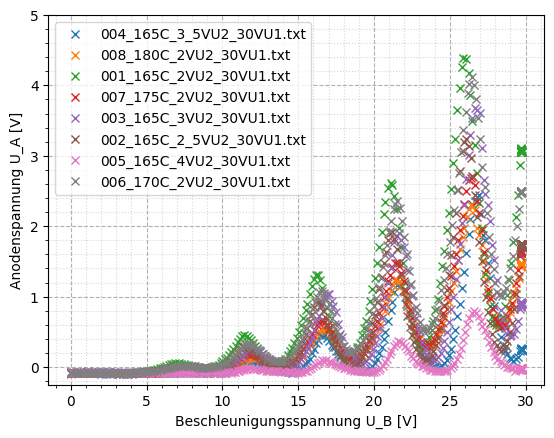

In [40]:
folder = "../data/franck_hertz"
txt_files = glob.glob(os.path.join(folder, "*.txt"))

plt.figure()

for f in txt_files:
    data = np.loadtxt(f, skiprows=1)
    plt.plot(data[:,0], data[:,1],'x' ,label=os.path.basename(f))
plt.xlabel(r'Beschleunigungsspannung U_B [V]')
plt.ylabel(r'Anodenspannung U_A [V]')
plt.ylim(-0.25,5)
plt.grid(visible=True, which="major", linestyle="--")
plt.minorticks_on()
plt.grid(visible=True, which="minor", linestyle=":", alpha=0.5)
plt.legend()
plt.show()



max(u_a) = 2.3
found peaks at indices: [ 90 123 157 191 216]
peak_centers: [11.9  16.65 21.55 26.4  29.7 ]
peak_amps: [0.14 0.55 1.24 2.3  1.48]


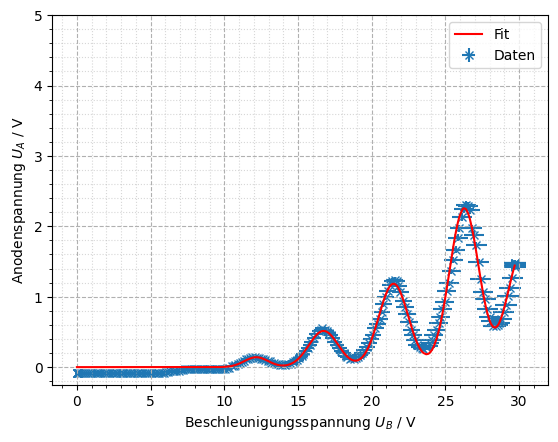

In [ ]:
# test method 

data = np.loadtxt("../data/franck_hertz/008_180C_2VU2_30VU1.txt", skiprows=1)
u_b = data[:,0]
u_a = data[:,1]

du_a = 0.02 * u_a + 0.005 * np.ptp(u_a)
du_b = 0.02 * u_b + 0.005 * np.ptp(u_b)

peaks, props = find_peaks(u_a, 
                          height=0.0, 
                          distance=20,
                          prominence=0.02*np.ptp(u_a))
peak_centers = u_b[peaks]
peak_amps = props['peak_heights']
if len(peak_centers) == 0:
    raise RuntimeError("No peaks found - try adjusting 'height', 'distance' or 'prominence' in find_peaks.")
print("max(u_a) =", np.max(u_a))
print("found peaks at indices:", peaks)
print("peak_centers:", peak_centers)
print("peak_amps:", peak_amps)

model = None
params = None
for i, (cen, amp) in enumerate(zip(peak_centers, peak_amps)):
    prefix = f'g{i}'
    gauss = GaussianModel(prefix=prefix)
    if model is None:
        model = gauss
        params = gauss.make_params()

    else:
        model += gauss
        params.update(gauss.make_params())

    params[prefix + 'center'].set(value=cen, min=cen-0.5, max=cen+0.5)
    params[prefix + 'amplitude'].set(value=amp, min=0)
    params[prefix + 'sigma'].set(value=0.3, min=0.05, max=1)

weights = 1.0 / du_a
result = model.fit(u_a, params, x=u_b, weights=weights)

plt.figure()
plt.errorbar(u_b, u_a, yerr=du_a, xerr=du_b, fmt='x', label='Daten', zorder=1)
plt.plot(u_b, result.best_fit, 'r-', label='Fit', zorder=2)
plt.grid(visible=True, which="major", linestyle="--")
plt.minorticks_on()
plt.grid(visible=True, which="minor", linestyle=":", alpha=0.5)
plt.ylim(-0.25,5)
plt.xlabel(r'Beschleunigungsspannung $U_B$ / V')
plt.ylabel(r'Anodenspannung $U_A$ / V')
plt.legend()
plt.show()

sigmas = [v for k,v in result.best_values.items() if k.endswith('sigma')]
mean_s, std_s = np.mean(sigmas), np.std(sigmas)

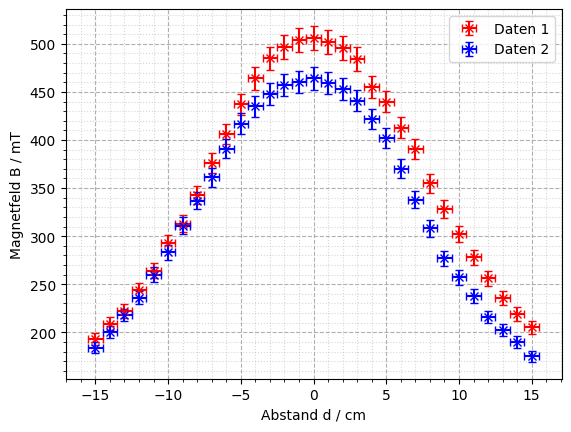

In [10]:
# data kalibration magnetfeld abstand
kal_data1 = np.loadtxt("../data/kal_magnet_ort.txt", skiprows=3)
kal_data2 = np.loadtxt("../data/kal_magnet_ort2.txt", skiprows=3)

# erste kalibration
d1 = kal_data1[:,0]
B1 = kal_data1[:,1]
d1_err = [0.5]*len(d1)
B1_err = np.array([a*0.02+max(B1)*0.005 for a in B1])

# zweite kalibration
d2 = kal_data2[:,0]
B2 = kal_data2[:,1]
d2_err = [0.5]*len(d2)
B2_err = np.array([a*0.02+max(B2)*0.005 for a in B2])
plt.figure()
plt.errorbar(d1, B1, xerr=d1_err, yerr=B1_err, fmt='rx', label='Daten 1', capsize=3)
plt.errorbar(d2, B2, xerr=d2_err, yerr=B2_err, fmt='bx', label='Daten 2', capsize=3)
plt.grid(visible=True, which="major", linestyle="--")
plt.minorticks_on()
plt.grid(visible=True, which="minor", linestyle=":", alpha=0.5)
plt.xlabel(r'Abstand d / cm')
plt.ylabel(r'Magnetfeld B / mT')
plt.legend()
plt.show()

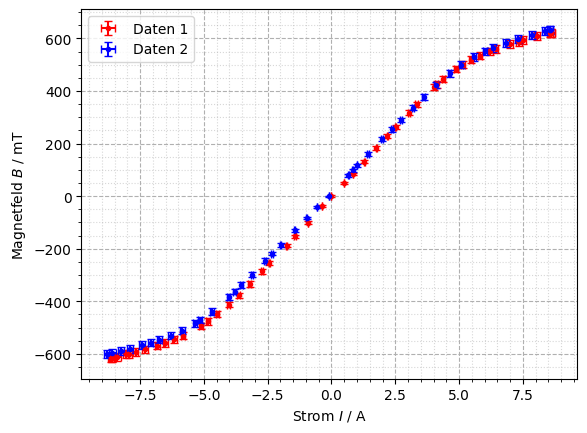

In [18]:
# data kalibration magnetfeld strom
kal_strom_data1 = np.loadtxt("../data/zeeman/Kalibration_01.txt", skiprows=2, delimiter=';')
kal_strom_data2 = np.loadtxt("../data/zeeman/Kalibration_02.txt", skiprows=2, delimiter=';')

I1 = kal_strom_data1[:,0]*-1
I1_err = np.array([a*0.015 for a in np.abs(I1)])
B1_strom = kal_strom_data1[:,1]
B1_strom_err = np.array([a*0.02+max(B1_strom)*0.005 for a in np.abs(B1_strom)])

I2 = kal_strom_data2[:,0]*-1
I2_err = np.array([a*0.015 for a in np.abs(I2)])
B2_strom = kal_strom_data2[:,1]
B2_strom_err = np.array([a*0.02+max(B2_strom)*0.005 for a in np.abs(B2_strom)])

plt.figure()
plt.errorbar(I1, B1_strom, xerr=I1_err, yerr=B1_strom_err, fmt='r.', label='Daten 1', capsize=3)
plt.errorbar(I2, B2_strom, xerr=I2_err, yerr=B2_strom_err, fmt='b.', label='Daten 2', capsize=3)
plt.grid(visible=True, which="major", linestyle="--")
plt.minorticks_on()
plt.grid(visible=True, which="minor", linestyle=":", alpha=0.5)
plt.xlabel(r'Strom $I$ / A')
plt.ylabel(r'Magnetfeld $B$ / mT')
plt.legend()
plt.show()

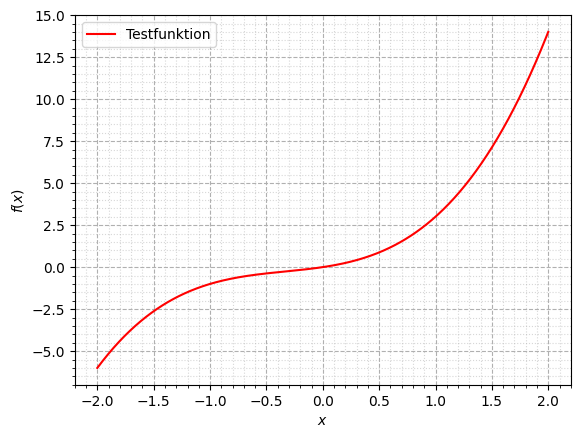

In [25]:
def func(x, a, b, c, d):
    return a*x**3 + b*x**2+ c*x + d

x = np.linspace(-2, 2, 500)
plt.figure()
plt.plot(x, func(x, 1, 1, 1, 0), 'r-', label='Testfunktion')
plt.grid(visible=True, which="major", linestyle="--")
plt.minorticks_on() 
plt.grid(visible=True, which="minor", linestyle=":", alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
plt.legend()
plt.show()